In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Path of the file to read.
data_path = "countries-aggregated_csv.csv"
# Reading the file
data = pd.read_csv(data_path )


# Checking if CUDA is available
from numba import cuda
print(f'Cuda is available: {cuda.is_available()}')

Cuda is available: True


## Simple Multi-Linear Regression modeling part

### Note: Multi-Linear Regression is a poor model for this type of data and should not be used. The modelling is done for testing purposes only!

Making target y and input X for the XGBRegressor model and then splitting X and y into validation and training data.

In [2]:
# Features
features = ['Confirmed', 'Recovered']
X = data[features]

# Target
y = data['Deaths']

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1)

# Preprocessing the training data.
# Normalizing the independent variables with StandardScaler
std_scaler = StandardScaler()
train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

Search space for hyperparameters.

In [6]:
# Define the search space
space = {
    'device': 'cuda',
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 18, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "random_state": 1,
    "seed": 0,
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "booster": "gbtree",
}

Method that trains the model with the given parameters and calculates the MAE score and returns loss, status of the model.

In [7]:
def get_params(space):
    # Inputing the parameters
    model = XGBRegressor(**space)
    
    # Evaluation set
    eval_set = [(train_X, train_y), (val_X, val_y)]

    # Fit the model on the eval_set with early stopping
    model.fit(train_X, train_y, eval_set=eval_set, eval_metric="mae", early_stopping_rounds=50, verbose=False)

    # Get model predictions
    y_pred = model.predict(val_X)

    # Calculate MAE
    mae = mean_absolute_error(val_y, y_pred)
    print(f"MAE: {mae}")

    return {'loss': mae, 'status': STATUS_OK, 'model': model}

Bayesian optimization algorithm to find the most optimized parameters for the model.

In [8]:
trials = Trials()

best_params = fmin(fn=get_params,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials)

MAE: 3411.577106928892                                
MAE: 3188.518443178432                                                         
MAE: 3320.3244841150727                                                        
MAE: 3652.689435123587                                                         
MAE: 3324.723851299129                                                         
MAE: 3115.8185345857332                                                        
MAE: 4237.489566906619                                                          
MAE: 3846.94338688125                                                           
MAE: 3187.9731151897395                                                         
MAE: 3203.8986077600616                                                         
MAE: 3757.568774166529                                                           
MAE: 4163.246036211185                                                           
MAE: 4193.306606853941                                   

Getting the best optimized model after 30 evaluations and printing the hyperparameters.

In [9]:
best_model = trials.best_trial['result']['model']
print("The best hyperparameters are:")
print(best_params)
print("\nThe best optimized model:")
print(best_model)

The best hyperparameters are:
{'gamma': 8.917089497424833, 'learning_rate': 0.2848103660125062, 'max_bin': 989.0, 'max_depth': 18.0, 'min_child_weight': 0.0, 'n_estimators': 968.0, 'reg_alpha': 0.5767327488979918, 'reg_lambda': 0.6201871247724405}

The best optimized model:
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=8.917089497424833, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2848103660125062,
             max_bin=989, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=None,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=968, n_jobs=None,
           

Testing how much better the optimized model is compared to the standard model.

In [10]:
# Testing the best model with the validation data
best_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
y_pred_best = best_model.predict(val_X)
mae = mean_absolute_error(val_y, y_pred_best)
print(f"MAE_Best_Model: {mae}")

# Testing the standard model with the validation data
standard_model = XGBRegressor()
standard_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
y_pred_std = standard_model.predict(val_X)
mae_std = mean_absolute_error(val_y, y_pred_std)
print(f"MAE_Standard_Model: {mae_std}")
print(f"MAE_Difference: {mae_std - mae}")

MAE_Best_Model: 3058.8867003407513
MAE_Standard_Model: 3789.3386424433143
MAE_Difference: 730.451942102563


The **optimized model** seems to work much better than the **standard XGBRegressor model**, so HyperOpt optimization is good tool for this kind of modeling. We could probably get a much better MAE score, if we would evaluate for a longer time and do more finetuning, but it is not necessary for now.

Let's check how the model performance looks.

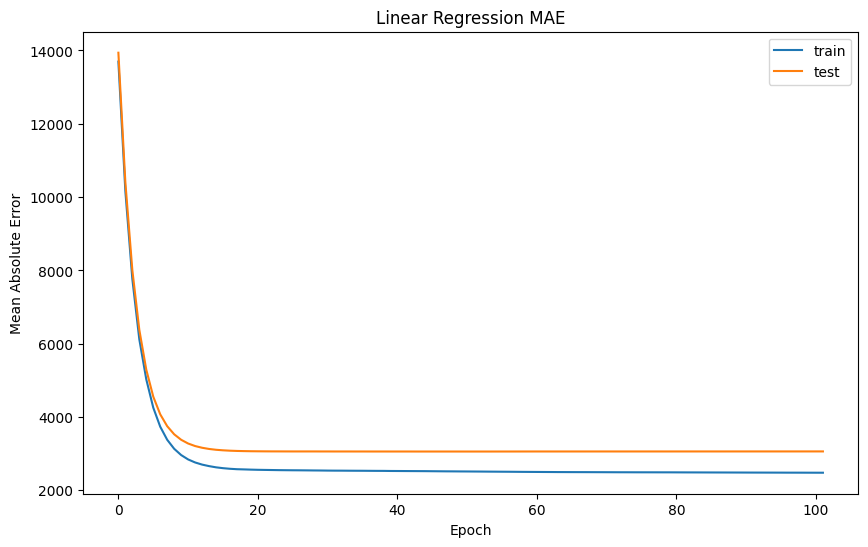

In [12]:
results = best_model.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='train')
plt.plot(results['validation_1']['mae'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Linear Regression MAE')
plt.legend()
plt.show()

Training **MAE** seems to decrease somewhere around 2000 and testing somewhere between 3000 - 3500, so model seems to undefit a little bit, because there probably is some noise in the data, which needs to be cleaned to prevent underfitting. We could also try using different linear regression models, but XGBoost seems to do a great job with HyperOpt optimisation, so it is not necessary.

The problem with this type of modelling is that it forces all countries to fit into a simple linear regression model, which does not give us any realistic or useful information, because we cannot get meaningful continuous predictions for certain countries. Instead, we should try to classify the countries with the features **'Confirmed'**, **'Recovered'** and **'Deaths'** and perhaps add some other features to the dataset that might give us more information. On the other hand, we could try to clustering and do some cluster analysis about the countries.

| **Date** | **Version**| **Change Description** |
| --- | --- | --- |
| 12.8.2024 | 1.0.1 | Moved the Regression part to the separate file and used StandardScaler instead of RobustScaler in the Regression modeling|